In [1]:
import numpy as np
import pandas as pd
from interpret.glassbox import ExplainableBoostingClassifier
from libraries.feature_selection import *
from data_preparation.data_preparation import transform_data
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from feature_engine.selection import SmartCorrelatedSelection
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import roc_auc_score
from data_preparation import metrics_eval
from interpret import show
from sklearn.preprocessing import StandardScaler

In [2]:
x_train, y_train = transform_data(pd.read_csv("datasets/in_time.csv"))
x_oot, y_oot = transform_data(pd.read_csv("datasets/out_of_time.csv"))

KeyError: "['limit_in_revolving_l`oans_H12'] not found in axis"

In [3]:
columns_to_scale=x_train.columns[x_train.dtypes==bool]
sc=StandardScaler()
x_train[columns_to_scale]=sc.fit_transform(x_train[columns_to_scale], y_train)
x_oot[columns_to_scale]=sc.transform(x_oot[columns_to_scale])

NameError: name 'x_train' is not defined

In [ ]:
x_train.max()

hasExternal_credit_card_balance    bool
hasExternal_term_loan_balance      bool
hasExternal_mortgage_balance       bool
hasActive_credit_card_lines        bool
hasActive_mortgages                bool
dtype: object

In [3]:
model_for_performance = LogisticRegression()
model= ExplainableBoostingClassifier(interactions=0.0)

pipe = Pipeline([
    #('preprocessing' ,full_pipeline_logisitic),
    #('droping not used', FunctionTransformer(lambda x: x.drop(['scale__remainder__customer_id', 'remainder__remainder__application_date', 'remainder__application_status_transform__Application_status', 'remainder__remainder__Application data: employment date (main applicant)'], axis=1))),
    ('Delete features with gini lower than 0.01', GiniSelector(0.01)), 
    ('Smart Correlated Selection', SmartCorrelatedSelection( variables=None,
                                                             method="spearman",
                                                             threshold=0.8,
                                                             missing_values="raise",
                                                             selection_method="model_performance",
                                                             estimator=model_for_performance,).set_output(transform="pandas")),
    #('Cleaning semi-manualy overly correlated featuers',OverCorrelatedDropper(0.6)),
    #('Logistic regression', model)
], verbose = True)
pipe.fit(x_train, y_train)

ValueError: Input contains infinity or a value too large for dtype('float64').

In [ ]:
x_transformed=pipe.transform(x_train)

In [ ]:
len(x_transformed.columns)

32

In [ ]:
corr=x_transformed.corr(method="spearman").values
for i in range(corr.shape[0]):
    for j in range(i):
        if(i!=j):
            if(corr[i,j]>=0.7):
                print(i,j)

In [4]:
model.fit(x_transformed,y_train)

NameError: name 'x_transformed' is not defined

In [10]:
importances=[(i,j) for i,j in zip(x_transformed.columns ,model.term_importances())]
variables=[i[0] for i in sorted(importances, key=lambda x: x[1],reverse=True)[:9]]
variables

['DPD_term_loan_H2',
 'Default_flag_H1',
 'Default_flag_H2',
 'DPD_term_loan_H3',
 'Default_flag_H3',
 'Default_flag_H4',
 'DPD_term_loan_H6',
 'Default_flag_H5',
 'DPD_term_loan_H4']

In [11]:
x_selected=x_transformed[variables]
model.fit(x_selected,y_train)

ExplainableBoostingClassifier(interactions=0.0)

In [25]:
pd.concat([x_selected, y_train], axis=1).to_csv("variable.csv")
pd.concat([x_oot[variables], y_oot], axis=1).to_csv("variable_oot.csv")

In [ ]:
""" 
('Sequential Feature Selector', SequentialFeatureSelector(model, 
                                                              n_features_to_select=9,
                                                              scoring='roc_auc', 
                                                              cv=5).set_output(transform="pandas")),

"""

In [13]:
y_train_predict=model.predict_proba(x_selected)[:,1]
y_oot_predict=model.predict_proba(x_oot[variables])[:,1]

In [14]:
roc_auc_score(y_train, y_train_predict)

0.7904241938115681

In [15]:
roc_auc_score(y_oot, y_oot_predict)

0.7431612554924669

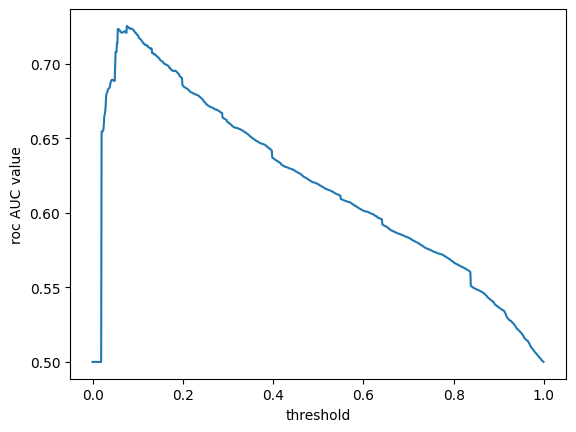

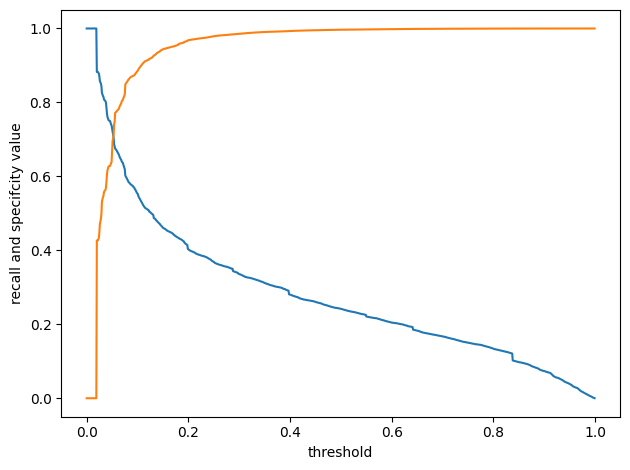

In [18]:
best_threshold=metrics_eval.find_best_threshold(y_train, y_train_predict)

In [22]:
best_threshold

(0.076, 0.7253864764043001)

In [23]:
metrics_eval.evaluate_model(model, x_selected, y_train, x_oot, y_oot,best_threshold[0])

Evaluating model: ExplainableBoostingClassifier


,Model,Dataset,AUC,Accuracy,Precision,Recall,F1-score
0,ExplainableBoostingClassifier,Train,0.790424,0.831732,0.226328,0.602157,0.328998
1,ExplainableBoostingClassifier,Test,0.743161,0.737513,0.198515,0.620552,0.300802


Evaluating model: ExplainableBoostingClassifier


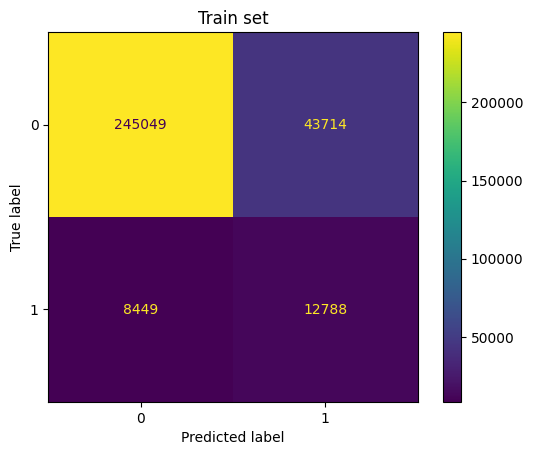

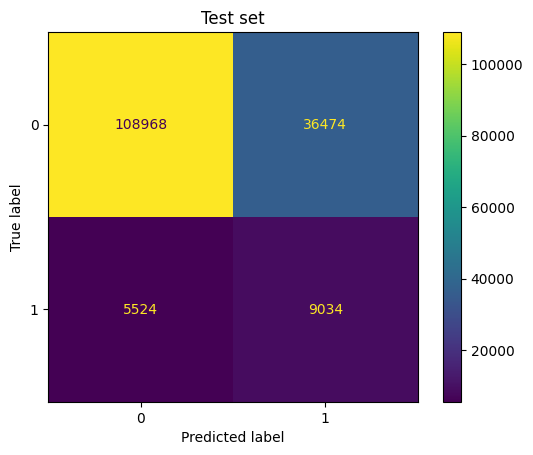

In [24]:
metrics_eval.confusion_matrices(model, x_selected, y_train, x_oot, y_oot,best_threshold[0])

In [28]:
show(model.explain_global())

<!-- http://127.0.0.1:7001/140714175378256/ -->

In [36]:
from interpret.blackbox import PartialDependence

pdp = PartialDependence(model, x_selected)

show(pdp.explain_global(), 0)

<!-- http://127.0.0.1:7001/140714251500112/ -->

In [37]:
from interpret.blackbox import PartialDependence

pdp = PartialDependence(model, x_oot[variables])

show(pdp.explain_global(), 0)

<!-- http://127.0.0.1:7001/140714191670160/ -->

In [39]:
model.term_importances()

array([0.29402944, 0.17624053, 0.13399494, 0.11338371, 0.11731511,
       0.11744859, 0.19427709, 0.12190706, 0.11605729])